In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from matplotlib import pyplot as plt
import torch.nn.functional as F


In [2]:
from region_proposal_network import RegionProposalNetwork
from bbox_tools import generate_anchor_base
from creator_tool import ProposalTargetCreator ,ProposalCreator

In [3]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device,torch.cuda.get_device_name(0))
else:
    device =torch.device("cpu")
    print(device)

cuda NVIDIA GeForce GTX 1650


In [4]:
import glob
import cv2
num_images =50
image_names = glob.glob(r"C:\Users\vrinda\Desktop\2ndsem\Summer_internship\data\Training\input\*.jpg")
image_names.sort()
imset = image_names[0:num_images]
# images = [cv2.imread(image,1) for image in image_names]
imset
img = [cv2.imread(imgs, 0) for imgs in imset]
img_dataset = np.array(img)

In [5]:
img_dataset.shape

(50, 512, 512)

In [6]:
num_grd = 50
ground_truth = glob.glob(r"C:\Users\vrinda\Desktop\2ndsem\Summer_internship\data\Training\Output\*.png")
ground_truth.sort()
grdset = ground_truth[0:num_grd]
masks = [cv2.imread(mask, 0) for mask in grdset]
mask_dataset = np.array(masks)

In [7]:
mask_dataset.shape

(50, 512, 512)

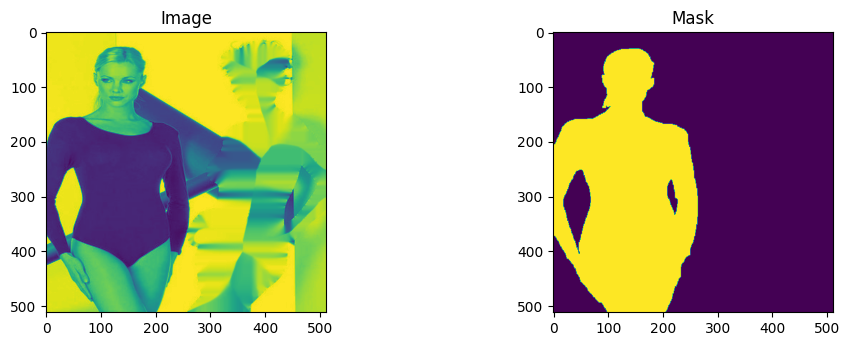

In [8]:
import random
img_number = random.randint(0, len(img_dataset)-1)
img = img_dataset[img_number]
mask = mask_dataset[img_number]
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [9]:
print(img_dataset)

[[[ 89  75  58 ... 138 139 140]
  [ 90  79  66 ... 138 139 140]
  [ 87  78  69 ... 138 139 140]
  ...
  [146 145 144 ...  59  58  57]
  [136 136 135 ...  59  58  58]
  [135 134 133 ...  57  57  56]]

 [[173 174 122 ... 129 126 115]
  [164 177 142 ... 129 126 116]
  [162 180 165 ... 128 125 117]
  ...
  [ 42  43  45 ... 117 123 127]
  [ 39  41  42 ... 123 135 141]
  [ 38  40  42 ... 130 147 153]]

 [[253 252 250 ...  57  68  83]
  [253 252 251 ...  69  84  98]
  [252 252 253 ...  66  71  74]
  ...
  [126 140 149 ... 182 172 198]
  [171 136 157 ... 154 151 179]
  [138 137 172 ... 154 145 178]]

 ...

 [[215 214 212 ...  53  46  46]
  [207 207 206 ...  70  50  32]
  [211 211 210 ...  70  44  17]
  ...
  [149 147 148 ... 220 232 238]
  [120 128 136 ... 221 223 216]
  [123 130 136 ... 192 194 196]]

 [[104 104 105 ... 102 102 102]
  [104 104 105 ... 102 102 102]
  [104 105 106 ... 102 102 102]
  ...
  [ 46  46  45 ...  28  23  23]
  [ 47  46  45 ...  27  23  22]
  [ 47  46  45 ...  27  23  

In [10]:
train_dataset, test_dataset = random_split(img_dataset, [0.75, 0.25])
batch_size = 8

train_transform = transforms.Compose([
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle test data


In [11]:
# Assuming you have created train_dataloader
for batch_images in train_dataloader:
    # batch_images is a tensor containing the images in the batch
    print(batch_images)
    # Access the batch size
    batch_size = batch_images.size(0)
    
    # Process the batch as needed
    # Example: Print the shape of the batch images
    print(f"Batch Size: {batch_size}")
    print(f"Batch Images Shape: {batch_images.shape}")
    break

tensor([[[173, 174, 122,  ..., 129, 126, 115],
         [164, 177, 142,  ..., 129, 126, 116],
         [162, 180, 165,  ..., 128, 125, 117],
         ...,
         [ 42,  43,  45,  ..., 117, 123, 127],
         [ 39,  41,  42,  ..., 123, 135, 141],
         [ 38,  40,  42,  ..., 130, 147, 153]],

        [[253, 253, 253,  ..., 163, 163, 163],
         [253, 253, 253,  ..., 163, 163, 163],
         [253, 253, 253,  ..., 163, 163, 163],
         ...,
         [ 23,  24,  27,  ..., 109, 113, 108],
         [ 25,  26,  28,  ..., 112, 113, 106],
         [ 28,  28,  29,  ..., 115, 112, 104]],

        [[180, 180, 181,  ...,  89,  89,  89],
         [178, 178, 178,  ...,  96,  96,  97],
         [178, 178, 179,  ..., 105, 105, 106],
         ...,
         [ 30,  31,  32,  ...,  50,  47,  45],
         [ 30,  31,  33,  ...,  49,  45,  45],
         [ 30,  31,  32,  ...,  49,  45,  47]],

        ...,

        [[249, 249, 249,  ..., 232, 231, 230],
         [249, 249, 249,  ..., 232, 232, 231]

## face detection

In [12]:
#it contains a backbone architecture and bilinear network
#backbone architecture
# class InceptionModule(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(InceptionModule, self).__init__()
#         self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
#         self.conv3x3_reduce = nn.Conv2d(in_channels, out_channels // 2, kernel_size=1)
#         self.conv3x3 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, padding=1)
#         self.conv5x5_reduce = nn.Conv2d(in_channels, out_channels // 4, kernel_size=1)
#         self.conv5x5 = nn.Conv2d(out_channels // 4, out_channels, kernel_size=5, padding=2)

#     def forward(self, x):
#         conv1x1 = self.conv1x1(x)
#         conv3x3 = self.conv3x3(self.conv3x3_reduce(x))
#         conv5x5 = self.conv5x5(self.conv5x5_reduce(x))
#         return torch.cat([conv1x1, conv3x3, conv5x5], dim=1)
class BackboneNetwork(nn.Module):
    def __init__(self):
        super(BackboneNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3,16, kernel_size=5, padding=2, stride=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16,24, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(24,48, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(48,48, kernel_size=3, padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(48,48, kernel_size=3, padding=1, stride=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(48,48, kernel_size=3, padding=1, stride=1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x) 
        x = self.pool1(x)

        x = self.conv2(x)
        x = torch.relu(x)  
        x = self.pool2(x)

        x = self.conv3(x)
        x = torch.relu(x)  
        x = self.pool3(x)

        x = self.conv4(x)
        x = torch.relu(x)  
        x = self.pool4(x)

        x = self.conv5(x)
        x = torch.relu(x)  
        x = self.pool5(x)

        x = self.conv6(x)
        x = torch.relu(x)  

        return x

        
        
        
        
        
        

In [13]:
nettt =  BackboneNetwork()
nettt

BackboneNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [76]:
class BackboneNetwork(nn.Module):
    def __init__(self):
        super(BackboneNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3,16, kernel_size=5, padding=2, stride=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16,24, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(24,48, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(48,48, kernel_size=3, padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(48,48, kernel_size=3, padding=1, stride=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(48,48, kernel_size=3, padding=1, stride=1)

    def forward(self, x):
        x = self.conv1(x)
        print("After conv1:", x.shape)
        x = torch.relu(x)
        x = self.pool1(x)
        print("After pool1:", x.shape)

        x = self.conv2(x)
        print("After conv2:", x.shape)
        x = torch.relu(x)
        x = self.pool2(x)
        print("After pool2:", x.shape)

        x = self.conv3(x)
        print("After conv3:", x.shape)
        x = torch.relu(x)
        x = self.pool3(x)
        print("After pool3:", x.shape)

        x = self.conv4(x)
        print("After conv4:", x.shape)
        x = torch.relu(x)
        x = self.pool4(x)
        print("After pool4:", x.shape)

        x = self.conv5(x)
        print("After conv5:", x.shape)
        x = torch.relu(x)
        x = self.pool5(x)
        print("After pool5:", x.shape)

        x = self.conv6(x)
        print("After conv6:", x.shape)
        x = torch.relu(x)

        return x

def _enumerate_shifted_anchor(anchor_base, feat_stride, height, width):
    # Enumerate all shifted anchors:
    #
    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    # return (K*A, 4)

    # !TODO: add support for torch.CudaTensor
    # xp = cuda.get_array_module(anchor_base)
    # it seems that it can't be boosed using GPU
    import numpy as xp
    shift_y = xp.arange(0, height * feat_stride, feat_stride)
    shift_x = xp.arange(0, width * feat_stride, feat_stride)
    shift_x, shift_y = xp.meshgrid(shift_x, shift_y)
    shift = xp.stack((shift_y.ravel(), shift_x.ravel(),
                      shift_y.ravel(), shift_x.ravel()), axis=1)

    A = anchor_base.shape[0]
    K = shift.shape[0]
    anchor = anchor_base.reshape((1, A, 4)) + \
             shift.reshape((1, K, 4)).transpose((1, 0, 2))
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor


def _enumerate_shifted_anchor_torch(anchor_base, feat_stride, height, width):
    # Enumerate all shifted anchors:
    #
    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    # return (K*A, 4)

    # !TODO: add support for torch.CudaTensor
    # xp = cuda.get_array_module(anchor_base)
    import torch as t
    shift_y = t.arange(0, height * feat_stride, feat_stride)
    shift_x = t.arange(0, width * feat_stride, feat_stride)
    shift_x, shift_y = xp.meshgrid(shift_x, shift_y)
    shift = xp.stack((shift_y.ravel(), shift_x.ravel(),
                      shift_y.ravel(), shift_x.ravel()), axis=1)

    A = anchor_base.shape[0]
    K = shift.shape[0]
    anchor = anchor_base.reshape((1, A, 4)) + \
             shift.reshape((1, K, 4)).transpose((1, 0, 2))
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor


def normal_init(m, mean, stddev, truncated=False):
    """
    weight initalizer: truncated normal and random normal.
    """
    # x is a parameter
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()



class RegionProposalNetwork(nn.Module):
    def __init__(
            self, in_channels=48, mid_channels=48, ratios=[0.5, 1, 2],
            anchor_scales=[8, 16, 32 ], feat_stride=16,
            proposal_creator_params=dict(),
    ):
        super(RegionProposalNetwork, self).__init__()
        self.anchor_base = generate_anchor_base(
            anchor_scales=anchor_scales, ratios=ratios)
        self.feat_stride = feat_stride
        self.proposal_layer = ProposalCreator(self, **proposal_creator_params)
        n_anchor = self.anchor_base.shape[0]
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        normal_init(self.conv1, 0, 0.01)
        normal_init(self.score, 0, 0.01)
        normal_init(self.loc, 0, 0.01)

    def forward(self, x, img_size, scale=1.):
        n, _, hh, ww = x.shape
        anchor = _enumerate_shifted_anchor(
            np.array(self.anchor_base),
            self.feat_stride, hh, ww)

        n_anchor = anchor.shape[0] // (hh * ww)
        h = F.relu(self.conv1(x))

        rpn_locs = self.loc(h)
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)
        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()
        rpn_softmax_scores = F.softmax(rpn_scores.view(n, hh, ww, n_anchor, 2), dim=4)
        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)

        rois = list()
        roi_indices = list()
        for i in range(n):
            roi = self.proposal_layer(
                rpn_locs[i].cpu().data.numpy(),
                rpn_fg_scores[i].cpu().data.numpy(),
                anchor, img_size,
                scale=scale)
            batch_index = i * np.ones((len(roi),), dtype=np.int32)
            rois.append(roi)
            roi_indices.append(batch_index)

        rois = np.concatenate(rois, axis=0)
        roi_indices = np.concatenate(roi_indices, axis=0)
        return rpn_locs, rpn_scores, rois, roi_indices, anchor   


In [77]:
# from PIL import Image
# image_path = r"C:\Users\vrinda\Desktop\2ndsem\Summer_internship\dataset\train\input\0_0000010.jpg"
# image = Image.open(image_path)
# image
# # Define preprocessing transformations
# preprocess = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize the image to match your network's input size
#     transforms.ToTensor(),           # Convert the PIL image to a PyTorch tensor
# #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
# ])
# input_data = preprocess(image).unsqueeze(0)

In [78]:
# # # Create an instance of the BackboneNetwork
# # backbone = BackboneNetwork()

# # # Create an instance of the RegionProposalNetwork
# # rpn = RegionProposalNetwork()

# # # Example input data with shape (batch_size, channels, height, width)
# # input_data = torch.randn(1, 3, 512, 512)

# # # Process input data using the BackboneNetwork
# # backbone_output = backbone(input_data)

# # # Process the backbone output using the RegionProposalNetwork
# # rpn_locs, rpn_scores, rois, roi_indices, anchor = rpn(backbone_output, img_size=(512, 512))
# import torch
# from PIL import Image
# from torchvision import transforms

# # Load the image using PIL or any other image loading library
# image_path = r"C:\Users\vrinda\Downloads\WhatsApp Image 2023-08-21 at 20.24.28.jpg"
# image = Image.open(image_path)

# # Define transformations to preprocess the image (resize, normalize, etc.)
# transform = transforms.Compose([
#     transforms.Resize((512, 512)),  # Resize to match your network input size
#     transforms.ToTensor(),           # Convert to tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
# ])

# # Apply the transformations to the image
# preprocessed_image = transform(image).unsqueeze(0)  # Add batch dimension

# # Create an instance of the BackboneNetwork
# backbone = BackboneNetwork()

# # Create an instance of the RegionProposalNetwork
# rpn = RegionProposalNetwork()

# # Process input data using the BackboneNetwork
# backbone_output = backbone(preprocessed_image)

# # Process the backbone output using the RegionProposalNetwork
# rpn_locs, rpn_scores, rois, roi_indices, anchor = rpn(backbone_output, img_size=(512, 512))



In [79]:
# print(anchor)
# print(rpn_locs)
# print(rpn_scores)
# print(rois)
# print(roi_indices)


After conv1: torch.Size([1, 16, 256, 256])
After pool1: torch.Size([1, 16, 128, 128])
After conv2: torch.Size([1, 24, 128, 128])
After pool2: torch.Size([1, 24, 64, 64])
After conv3: torch.Size([1, 48, 64, 64])
After pool3: torch.Size([1, 48, 32, 32])
After conv4: torch.Size([1, 48, 32, 32])
After pool4: torch.Size([1, 48, 16, 16])
After conv5: torch.Size([1, 48, 16, 16])
After pool5: torch.Size([1, 48, 8, 8])
After conv6: torch.Size([1, 48, 8, 8])


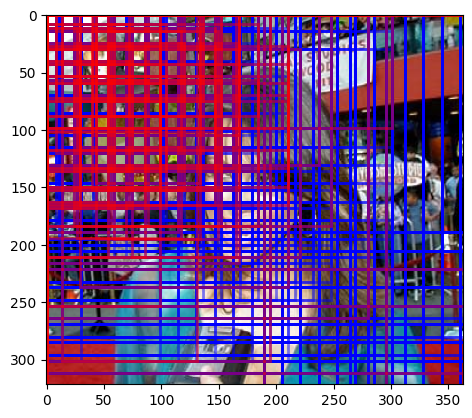

In [80]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle

# # Convert anchor and proposal coordinates to integer values for calculations
# anchor_int = anchor.astype(int)
# rois_int = rois.astype(int)

# # Load the image on which you want to draw the bounding boxes
# image_path = r"C:\Users\vrinda\Downloads\WhatsApp Image 2023-08-21 at 20.24.28.jpg"
# image = plt.imread(image_path)

# # Display the image
# plt.imshow(image)

# # Draw anchor boxes in blue
# for anchor_box_int, anchor_box in zip(anchor_int, anchor):
#     y1_int, x1_int, y2_int, x2_int = anchor_box_int
#     y1, x1, y2, x2 = anchor_box
#     plt.gca().add_patch(Rectangle((y1,x1),  y2 - y1,x2 - x1, fill=False, edgecolor='blue', linewidth=2))

# # # Draw proposal boxes in red
# for roi_int, roi in zip(rois_int, rois):
#     y1_int, x1_int, y2_int, x2_int = roi_int
#     y1, x1, y2, x2 = roi
#     plt.gca().add_patch(Rectangle(( y1,x1),  y2 - y1, x2 - x1,fill=False, edgecolor='red', linewidth=2))

# plt.show()
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Load the image using PIL or any other image loading library
image_path = r"C:\Users\vrinda\Downloads\WhatsApp Image 2023-08-21 at 20.24.28.jpg"
image = Image.open(image_path)

# Define transformations to preprocess the image (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to match your network input size
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Apply the transformations to the image
preprocessed_image = transform(image).unsqueeze(0)  # Add batch dimension

# Create an instance of the BackboneNetwork
backbone = BackboneNetwork()

# Create an instance of the RegionProposalNetwork
rpn = RegionProposalNetwork()

# Process input data using the BackboneNetwork
backbone_output = backbone(preprocessed_image)

# Process the backbone output using the RegionProposalNetwork
rpn_locs, rpn_scores, rois, roi_indices, anchor = rpn(backbone_output, img_size=(512, 512))

# Convert anchor and proposal coordinates to integer values for calculations
anchor_int = anchor.astype(int)

rois_int = rois.astype(int)


# Convert proposal coordinates to (y1, x1, y2, x2) format
rois_int = rois_int[:, [1, 0, 3, 2]]

# Load the image for visualization
image_for_visualization = plt.imread(image_path)

# Display the image
plt.imshow(image_for_visualization)

# Draw anchor boxes in different shades of blue
for i, (anchor_box_int, anchor_box) in enumerate(zip(anchor_int, anchor)):
    y1_int, x1_int, y2_int, x2_int = anchor_box_int
    y1, x1, y2, x2 = anchor_box
    plt.gca().add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=f'blue', linewidth=2, alpha=0.5))

# Draw proposal boxes in different shades of red
for i, (roi_int, roi) in enumerate(zip(rois_int, rois)):
    y1_int, x1_int, y2_int, x2_int = roi_int
    y1, x1, y2, x2 = roi
    plt.gca().add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=f'red', linewidth=2, alpha=0.5))

plt.show()
